In [1]:
import pandas as pd
import shapely
import numpy as np
import sys
import torch
import argparse
import random
import math
import os
import warnings
from gensim.models import word2vec
from shapely.geometry import LineString, Polygon
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler# 好处在于可以保存训练集中的参数（均值、方差）
from scipy.stats import stats
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
import gc
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# calculate the right features of each polygon

In [68]:
polys = []
with open("../points.txt","r") as f:
    for li in f:
        polys.append(li[:-1])

In [69]:
polys = [i.split(";") for i in polys]
#polys = []

In [70]:
for poly in polys:
    poly[0] = " "+poly[0]

In [71]:
new_polys = []
for poly in polys:
    temp = []
    for index, coord in enumerate(poly):
        if index<len(poly)-1 and coord == poly[index+1]:
            continue
        else:
            temp.append(coord)
    new_polys.append(';'.join(temp))

0


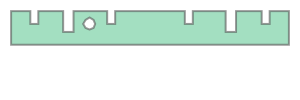

1


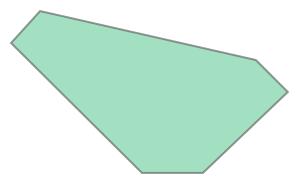

2


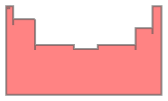

3


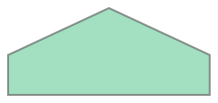

4


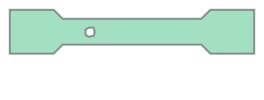

5


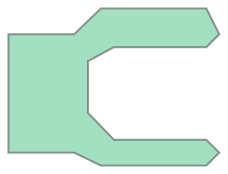

6


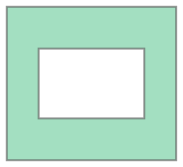

7


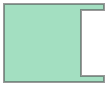

8


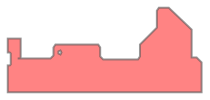

9


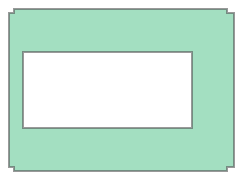

10


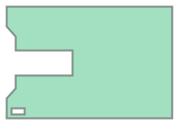

11


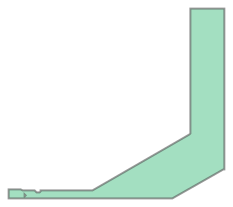

12


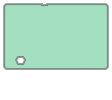

13


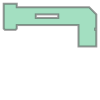

14


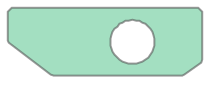

15


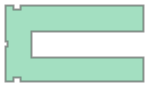

16


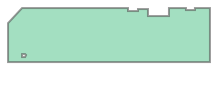

17


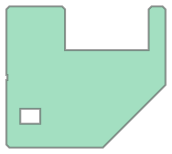

18


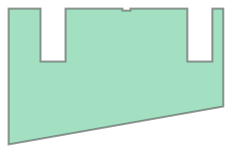

19


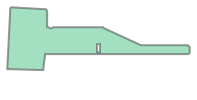

20


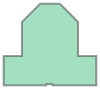

21


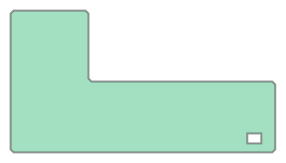

22


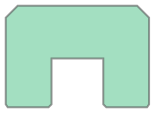

23


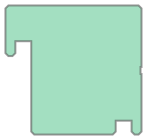

24


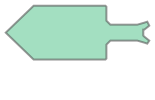

25


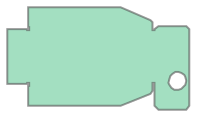

26


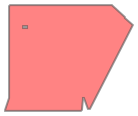

27


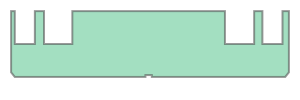

28


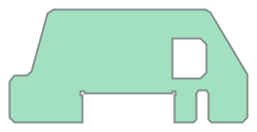

29


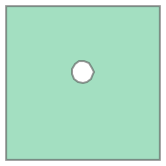

30


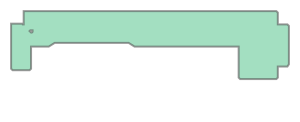

31


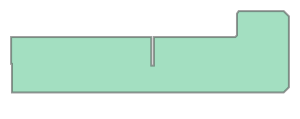

32


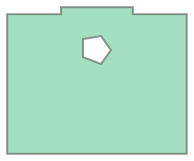

33


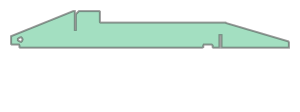

34


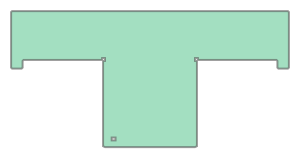

35


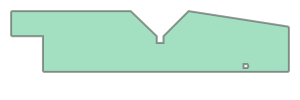

36


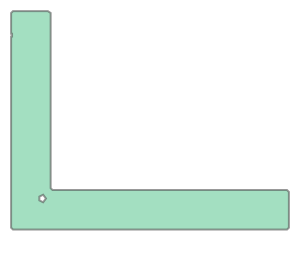

37


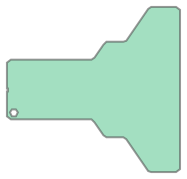

38


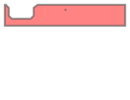

39


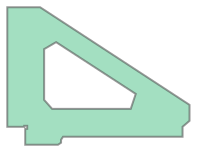

40


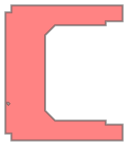

41


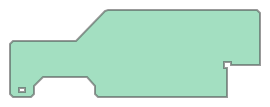

42


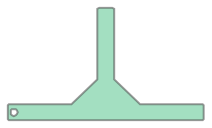

43


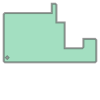

44


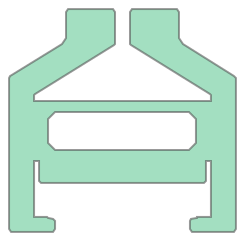

45


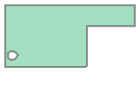

46


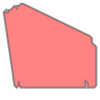

47


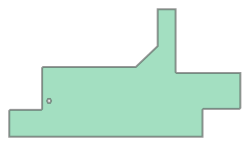

48


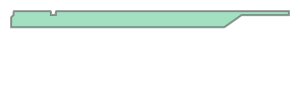

49


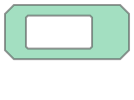

50


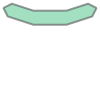

51


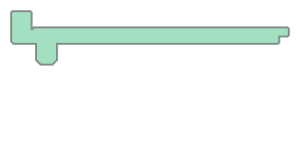

52


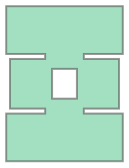

53


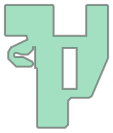

In [73]:
polygon_list = []

for index, poly in enumerate(new_polys):
    if "--" in poly:
        print(index)
        b = poly.split(";--;")
        vor = b[0]
        nach = b[1]

        b = vor.split(";")
        c = [l.strip() for l in b]
        x = [float(l.split(" ")[0]) for l in c ]
        y = [float(l.split(" ")[1]) for l in c ]
        xy = [(x[i], y[i]) for i in range(len(x))]

        b = nach.split(";")
        c = [l.strip() for l in b]
        x = [float(l.split(" ")[0]) for l in c ]
        y = [float(l.split(" ")[1]) for l in c ]
        xy1 = [(x[i], y[i]) for i in range(len(x))]


        polygon = Polygon(xy,[xy1])
        polygon
        polygon_list.append(polygon)
    else:
        print(index)
        b = poly.split(";")
        c = [l.strip() for l in b]
        x = [float(l.split(" ")[0]) for l in c ]
        y = [float(l.split(" ")[1]) for l in c ]
        xy = [(x[i], y[i]) for i in range(len(x))]
        polygon = Polygon(xy)
        polygon
        polygon_list.append(polygon)

# Version 1
Seq to seq model: target use the scores + high + use rate

In [109]:
# read file
#data = pd.read_pickle('../data/thread_0_0_999.pkl')
data = pd.read_pickle('../sample.tmp')

In [7]:
data_temp = pd.read_pickle('../sample3.tmp')

FileNotFoundError: [Errno 2] No such file or directory: '../sample3.tmp'

In [116]:
data = pd.concat([data,data_temp])

In [117]:
data.shape

(4000000, 13)

In [120]:
del data
gc.collect()

0

## prepare the data
what kinds of data do we need
- vector representation of the 'Teile' 
- vector representation of the rotation
- number of knote in the Teile
- normalized area of teile
- normalized circle of teile
- normlized area/circle of teile
- normalized left down of teile
- normalized right down of teile
- normalized area/circle after convexing
- normalized length/width
- normalized centroid x/width
- normalized centroid y/length

In [119]:
df = data.copy()
df.head()

Jobid    Rot                                List of Coordinates  \
0  792-0_10_0  90.00  [(159.0, 49.0), (167.0, 44.0), (168.0, 44.0), ...   
1  792-0_10_1   0.00  [(199.0, 158.0), (93.0, 158.0), (66.0, 132.0),...   
2  792-0_10_2  90.00  [(20.0, 138.0), (20.0, 138.0), (20.0, 138.0), ...   
3  792-0_10_3   0.00  [(150.0, 128.0), (149.0, 128.0), (149.0, 92.0)...   
4  792-0_10_4  90.00  [(199.0, 158.0), (93.0, 158.0), (66.0, 132.0),...   

                                     Shapely Polygon Metric1 Metric2 Metric3  \
0  POLYGON ((159 49, 167 44, 168 44, 308 44, 308 ...    1.00    1.00    1.00   
1  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13...    2.00    1.00   96.00   
2  POLYGON ((20 138, 20 138, 20 138, 19 138, 17 1...    3.00    1.00  311.00   
3  POLYGON ((150 128, 149 128, 149 92, 149 91, 12...    4.00    2.00  453.00   
4  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13...    5.00    6.00  678.00   

  Metric4      Area   Length       Left down      right down  score  
0    2.00 20543.000 1270.063     (93.0, 1.0)   (93.0, 377.0)  0.000  
1    4.00 18230.000  919.686   (213.0, 96.0)  (213.0, 254.0)  4.000  
2    4.00 12481.500 1028.849  (139.0, 311.0)  (139.0, 494.0)  4.000  
3    4.00 14654.000 1000.590  (234.0, 453.0)  (234.0, 581.0)  4.000  
4    2.00 18230.000  919.686  (164.0, 678.0)  (164.0, 890.0)  0.000

In [57]:
len(df.iloc[:1000].Area.unique())
# It contains all 54 figure, because there are 54 different area

54

In [94]:
def area_quote_calculation(x):
    bounds_x = x.bounds[2]
    bounds_y = x.bounds[3]
    return x.area/(bounds_x*bounds_y)

def convex_area_quote_calculation(polygon):
    convex_hull_x, convex_hull_y = [z.tolist() for z in polygon.convex_hull.exterior.coords.xy]
    convex_polygon = Polygon(zip(convex_hull_x,convex_hull_y))
    convex_area_quote = convex_polygon.area/(convex_polygon.bounds[2]*convex_polygon.bounds[3])
    convex_area = convex_polygon.area
    quote = polygon.area / convex_area
    return convex_area_quote, convex_area, quote

result = []
for polygon in polygon_list:
    temp=[]
    temp.append(polygon)
    temp.append(polygon.area)
    temp.append(polygon.length)
    temp.append(area_quote_calculation(polygon))
    convex_area_quote, convex_area, area_verhaltnis = convex_area_quote_calculation(polygon)
    temp.append(convex_area_quote)
    temp.append(convex_area)
    temp.append(area_verhaltnis)
    temp.append(polygon.centroid.x/polygon.bounds[2])
    temp.append(polygon.centroid.y/polygon.bounds[3])
    temp.append(polygon.bounds[2]/polygon.bounds[3])
    
    result.append(temp)

In [137]:
poly.exterior.coords

In [95]:
features  = pd.DataFrame(result,columns=["Shapely Polygon", "Area", "length", "area quote", 
                                         "convex area quote", "convex area", "area verhaltnis", 
                                         "centroid x/width", "centroid y/height","width/height" ] )

In [96]:
features["bounding box"] = features["Shapely Polygon"].map(lambda x : x.bounds)

In [97]:
features.head()

Shapely Polygon      Area   length  \
0  POLYGON ((0 0, 347 0, 347 42, 323 42, 323 26, ... 13108.000 1054.864   
1  POLYGON ((0 130, 29 162, 245 113, 277 81, 192 ... 25080.500  672.899   
2  POLYGON ((129 50, 92 50, 92 46, 68 46, 68 50, ...  9188.000  622.828   
3  POLYGON ((202 0, 0 0, 0 40, 101 87, 202 40, 20... 12827.000  504.800   
4  POLYGON ((201 0, 245 0, 245 44, 201 44, 192 35...  8048.000  623.507   

   area quote  convex area quote  convex area  area verhaltnis  \
0       0.899              1.000    14574.000            0.899   
1       0.559              0.559    25080.500            1.000   
2       0.662              1.000    13884.000            0.662   
3       0.730              0.730    12827.000            1.000   
4       0.747              1.000    10780.000            0.747   

   centroid x/width  centroid y/height  width/height              bounding box  
0             0.503              0.474         8.262   (0.0, 0.0, 347.0, 42.0)  
1             0.507              0.508         1.710  (0.0, 0.0, 277.0, 162.0)  
2             0.492              0.351         1.753   (0.0, 0.0, 156.0, 89.0)  
3             0.500              0.382         2.322   (0.0, 0.0, 202.0, 87.0)  
4             0.501              0.500         5.568   (0.0, 0.0, 245.0, 44.0)

# Make useful identifier

In [66]:
# filter out some false features. because of the inner contour

In [121]:
df["bounding box"] = df["Shapely Polygon"].map(lambda x : x.bounds)

In [126]:
#del df["Area"]
#del df["Length"]
del df["Shapely Polygon"]
df = pd.merge(df, features, how="left", on="bounding box")

In [127]:
gc.collect()

2007

In [130]:
df.head()

Jobid    Rot Metric1 Metric2 Metric3 Metric4       Left down  \
0  792-0_10_0  90.00    1.00    1.00    1.00    2.00     (93.0, 1.0)   
1  792-0_10_1   0.00    2.00    1.00   96.00    4.00   (213.0, 96.0)   
2  792-0_10_2  90.00    3.00    1.00  311.00    4.00  (139.0, 311.0)   
3  792-0_10_3   0.00    4.00    2.00  453.00    4.00  (234.0, 453.0)   
4  792-0_10_4  90.00    5.00    6.00  678.00    2.00  (164.0, 678.0)   

       right down  score              bounding box  \
0   (93.0, 377.0)  0.000   (0.0, 0.0, 376.0, 92.0)   
1  (213.0, 254.0)  4.000  (0.0, 0.0, 212.0, 158.0)   
2  (139.0, 494.0)  4.000  (0.0, 0.0, 183.0, 138.0)   
3  (234.0, 581.0)  4.000  (0.0, 0.0, 232.0, 128.0)   
4  (164.0, 890.0)  0.000  (0.0, 0.0, 212.0, 158.0)   

                                     Shapely Polygon      Area   length  \
0  POLYGON ((159 49, 167 44, 168 44, 308 44, 308 ... 20525.000 1008.101   
1  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   
2  POLYGON ((20 138, 19 138, 17 138, 16 138, 0 13... 12481.500  839.767   
3  POLYGON ((150 128, 149 128, 149 92, 149 91, 12... 14630.000  716.843   
4  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   

   area quote  convex area quote  convex area  area verhaltnis  \
0       0.593              0.932    32244.000            0.637   
1       0.544              0.938    31429.000            0.580   
2       0.494              0.678    17130.000            0.729   
3       0.493              0.708    21019.500            0.696   
4       0.544              0.938    31429.000            0.580   

   centroid x/width  centroid y/height  width/height  
0             0.540              0.658         4.087  
1             0.412              0.501         1.342  
2             0.394              0.416         1.326  
3             0.517              0.309         1.812  
4             0.412              0.501         1.342

In [131]:
del df["Metric4"]
del df["Metric3"]
del df["Metric2"]
del df["Metric1"]

In [132]:
gc.collect()

479

In [134]:
df.head()

Jobid    Rot       Left down      right down  score  \
0  792-0_10_0  90.00     (93.0, 1.0)   (93.0, 377.0)  0.000   
1  792-0_10_1   0.00   (213.0, 96.0)  (213.0, 254.0)  4.000   
2  792-0_10_2  90.00  (139.0, 311.0)  (139.0, 494.0)  4.000   
3  792-0_10_3   0.00  (234.0, 453.0)  (234.0, 581.0)  4.000   
4  792-0_10_4  90.00  (164.0, 678.0)  (164.0, 890.0)  0.000   

               bounding box  \
0   (0.0, 0.0, 376.0, 92.0)   
1  (0.0, 0.0, 212.0, 158.0)   
2  (0.0, 0.0, 183.0, 138.0)   
3  (0.0, 0.0, 232.0, 128.0)   
4  (0.0, 0.0, 212.0, 158.0)   

                                     Shapely Polygon      Area   length  \
0  POLYGON ((159 49, 167 44, 168 44, 308 44, 308 ... 20525.000 1008.101   
1  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   
2  POLYGON ((20 138, 19 138, 17 138, 16 138, 0 13... 12481.500  839.767   
3  POLYGON ((150 128, 149 128, 149 92, 149 91, 12... 14630.000  716.843   
4  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   

   area quote  convex area quote  convex area  area verhaltnis  \
0       0.593              0.932    32244.000            0.637   
1       0.544              0.938    31429.000            0.580   
2       0.494              0.678    17130.000            0.729   
3       0.493              0.708    21019.500            0.696   
4       0.544              0.938    31429.000            0.580   

   centroid x/width  centroid y/height  width/height  
0             0.540              0.658         4.087  
1             0.412              0.501         1.342  
2             0.394              0.416         1.326  
3             0.517              0.309         1.812  
4             0.412              0.501         1.342

In [139]:
# get num of corr

df['num_of_corr'] = df['Shapely Polygon'].map(lambda x: len(list(x.exterior.coords)))
#features["num_of_corr"] = features["Shapely Polygon"].map(lambda x:len(list(x.boundary.coords)))
#del features["Shapely Polygon"]

In [142]:
#df[3000000:].to_csv("feature2.csv")

In [34]:
data = pd.read_csv("feature.csv", index_col = [0])

In [5]:
temp = pd.read_csv("feature2.csv", index_col = [0])

In [6]:
data = pd.concat([data,temp])

In [7]:
#-------------------------------------------------------------------------------

In [8]:
df = data.copy()

In [9]:
df.head()

Jobid    Rot       Left down      right down  score  \
0  792-0_10_0 90.000     (93.0, 1.0)   (93.0, 377.0)  0.000   
1  792-0_10_1  0.000   (213.0, 96.0)  (213.0, 254.0)  4.000   
2  792-0_10_2 90.000  (139.0, 311.0)  (139.0, 494.0)  4.000   
3  792-0_10_3  0.000  (234.0, 453.0)  (234.0, 581.0)  4.000   
4  792-0_10_4 90.000  (164.0, 678.0)  (164.0, 890.0)  0.000   

               bounding box  \
0   (0.0, 0.0, 376.0, 92.0)   
1  (0.0, 0.0, 212.0, 158.0)   
2  (0.0, 0.0, 183.0, 138.0)   
3  (0.0, 0.0, 232.0, 128.0)   
4  (0.0, 0.0, 212.0, 158.0)   

                                     Shapely Polygon      Area   length  \
0  POLYGON ((159 49, 167 44, 168 44, 308 44, 308 ... 20525.000 1008.101   
1  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   
2  POLYGON ((20 138, 19 138, 17 138, 16 138, 0 13... 12481.500  839.767   
3  POLYGON ((150 128, 149 128, 149 92, 149 91, 12... 14630.000  716.843   
4  POLYGON ((199 158, 93 158, 66 132, 0 132, 0 13... 18230.000  919.686   

   area quote  convex area quote  convex area  area verhaltnis  \
0       0.593              0.932    32244.000            0.637   
1       0.544              0.938    31429.000            0.580   
2       0.494              0.678    17130.000            0.729   
3       0.493              0.708    21019.500            0.696   
4       0.544              0.938    31429.000            0.580   

   centroid x/width  centroid y/height  width/height  num_of_corr  
0             0.540              0.658         4.087           31  
1             0.412              0.501         1.342           17  
2             0.394              0.416         1.326           22  
3             0.517              0.309         1.812           26  
4             0.412              0.501         1.342           17

In [11]:
df["Jobid"] = df["Jobid"].astype(str)

In [12]:
def str_to_tuple(string):
    string = string[1:-1]
    string = string.split(",")
    string = [l.strip() for l in string]
    return (float(string[0]), float(string[1]))
df["Left down"] = df["Left down"].map(str_to_tuple)

In [13]:
df["right down"] = df["right down"].map(str_to_tuple)

In [14]:
df["bounding box"] = df["bounding box"].map(str_to_tuple)

In [15]:
#df.isnull().values.any()

In [ ]:
# add part embedding
# parts embedding, not tested jet.

# feature selection
df2 = data[['norm_area', 'length', 'area quote', 'convex area quote', 'convex area', 'area verhaltnis', 'centroid x/width',
        'centroid y/height', 'num_of_corr', 'A/L']]
df2 = df2.drop_duplicates()
df2['type'] = df2.index
# set container and meanshift cluster model
from sklearn.cluster import MeanShift
df_cluster = pd.DataFrame(df2['type'], index=df2.index)
ms = MeanShift()
# level x
for i in range(len(df2.columns)):
    _, items = get_combinations(i+1, df2.columns, si = 0, com = [])
    for col in tqdm(items):
        if col == 'type':
            continue
        clustering = ms.fit(df2[col])
        df_cluster.loc[:, 'clustering after ' + str(col)] = clustering.labels_
# only take the cluster which menge between 10 and 30
out = []
df_cluster.apply(lambda x: [out.append(df2['type'][x == i]) for i, j in zip(x.value_counts().index, x.value_counts().tolist()) if j < 30 and j > 10])
# change data type
out = [i.tolist() for i in out]
# create sentences from the cluster
sentences = []
for i in tqdm(out):
    num_sents = random.randint(5, 20)
    len_sents = random.randint(min(len(i), 5), min(len(i), 20))
    counter = 0
    for j in range(num_sents):
        tmp = []
        counter = 0
        while counter < len_sents:
            chosen = random.choice(i)
            if str(chosen) in tmp:
                continue
            tmp.append(str(chosen))
            counter = counter + 1
        sentences.append(tmp)
# train w2v model
model = word2vec.Word2Vec(sentences, min_count = 5, size = 8)
# merge back to dataframe on length
df2['wv'] = df2['type'].map(lambda x: model.wv[str(x)])
data = data.merge(df2[['length', 'wv']], how = 'left', on = 'length')
# 
data['wv0'] = data['wv'].map(lambda x: x[0])
data['wv1'] = data['wv'].map(lambda x: x[1])
data['wv2'] = data['wv'].map(lambda x: x[2])
data['wv3'] = data['wv'].map(lambda x: x[3])
data['wv4'] = data['wv'].map(lambda x: x[4])
data['wv5'] = data['wv'].map(lambda x: x[5])
data['wv6'] = data['wv'].map(lambda x: x[6])
data['wv7'] = data['wv'].map(lambda x: x[7])

In [16]:
# get onehot data for rotation
df['Rot'][df['Rot'] == 5.00] = 0.00
# get onehot data

In [17]:
ohe = OneHotEncoder()
tmp = ohe.fit_transform(df['Rot'].values.reshape(-1, 1)).toarray()
tmp = pd.DataFrame(tmp)
tmp.columns = ['r1', 'r2']
df = pd.concat([df, tmp], axis = 1)

In [18]:
del tmp
gc.collect()

0

In [19]:
# al = area /length
df['A/L'] = df['Area']/df['length']

In [20]:
# get coordinate of echo value
df['Left_down_x'] = df['Left down'].map(lambda x: x[0])
df['Left_down_y'] = df['Left down'].map(lambda x: x[1])
df['Right_down_y'] = df['right down'].map(lambda x: x[1])

In [21]:
df.columns

Index(['Jobid', 'Rot', 'Left down', 'right down', 'score', 'bounding box',
       'Shapely Polygon', 'Area', 'length', 'area quote', 'convex area quote',
       'convex area', 'area verhaltnis', 'centroid x/width',
       'centroid y/height', 'width/height', 'num_of_corr', 'r1', 'r2', 'A/L',
       'Left_down_x', 'Left_down_y', 'Right_down_y'],
      dtype='object')

In [23]:
# normalize the area, Length, num_of_corr, Left_down_x, Left_down_y, Right_down_y, A/L ...
scaler_area = MinMaxScaler().fit(df['Area'].values.reshape(-1, 1))
scaler_length = MinMaxScaler().fit(df['length'].values.reshape(-1, 1))
scaler_num_of_corr = MinMaxScaler().fit(df['num_of_corr'].values.reshape(-1, 1))
scaler_al = MinMaxScaler().fit(df['A/L'].values.reshape(-1, 1))

scaler_area_quote = MinMaxScaler().fit(df['area quote'].values.reshape(-1, 1))
scaler_convex_area_quote = MinMaxScaler().fit(df['convex area quote'].values.reshape(-1, 1))
scaler_centroid_x_width = MinMaxScaler().fit(df['centroid x/width'].values.reshape(-1, 1))
scaler_centroid_y_height = MinMaxScaler().fit(df['centroid y/height'].values.reshape(-1, 1))
scaler_widt_height = MinMaxScaler().fit(df['width/height'].values.reshape(-1, 1))
scaler_convex_area = MinMaxScaler().fit(df['convex area'].values.reshape(-1, 1))
scaler_area_verhaltnis = MinMaxScaler().fit(df['area verhaltnis'].values.reshape(-1, 1))

scaler_ldx = StandardScaler().fit(df['Left_down_x'].values.reshape(-1, 1))
scaler_ldy = StandardScaler().fit(df['Left_down_y'].values.reshape(-1, 1))
scaler_rdy = StandardScaler().fit(df['Right_down_y'].values.reshape(-1, 1))

In [24]:
df['norm_area'] = scaler_area.transform(df['Area'].values.reshape(-1, 1))
df['length'] = scaler_length.transform(df['length'].values.reshape(-1, 1))
df['num_of_corr'] = scaler_num_of_corr.transform(df['num_of_corr'].values.reshape(-1, 1))
df['A/L'] = scaler_al.transform(df['A/L'].values.reshape(-1, 1))

df['area quote'] = scaler_area_quote.transform(df['area quote'].values.reshape(-1, 1))
df['convex area quote'] = scaler_convex_area_quote.transform(df['convex area quote'].values.reshape(-1, 1))
df['centroid x/width'] = scaler_centroid_x_width.transform(df['centroid x/width'].values.reshape(-1, 1))
df['centroid y/height'] = scaler_centroid_y_height.transform(df['centroid y/height'].values.reshape(-1, 1))
df['width/height'] = scaler_widt_height.transform(df['width/height'].values.reshape(-1, 1))
df['convex area'] = scaler_convex_area.transform(df['convex area'].values.reshape(-1, 1))
df['area verhaltnis'] = scaler_area_verhaltnis.transform(df['area verhaltnis'].values.reshape(-1, 1))

df['norm_left_down_x'] = scaler_ldx.transform(df['Left_down_x'].values.reshape(-1, 1))
df['norm_left_down_y'] = scaler_ldy.transform(df['Left_down_y'].values.reshape(-1, 1))
df['norm_right_down_y'] = scaler_rdy.transform(df['Right_down_y'].values.reshape(-1, 1))

In [25]:
df.to_pickle("all_norm_feature.pkl")

In [33]:
df['Jobid']

0            792-0_10
1            792-0_10
2            792-0_10
3            792-0_10
4            792-0_10
5            792-0_10
6            792-0_10
7            792-0_10
8            792-0_10
9            792-0_10
10           792-0_10
11           792-0_10
12           792-0_10
13           792-0_10
14           792-0_10
15           792-0_10
16           792-0_10
17           792-0_10
18           792-0_10
19           792-0_10
20           792-0_10
21           792-0_10
22           792-0_10
23           792-0_10
24           792-0_10
25           792-0_10
26           792-0_10
27           792-0_10
28           792-0_10
29           792-0_10
              ...    
3999970     792-847_1
3999971     792-847_1
3999972     792-847_1
3999973     792-847_1
3999974    792-847_20
3999975    792-847_20
3999976    792-847_20
3999977    792-847_20
3999978    792-847_20
3999979    792-847_20
3999980    792-847_20
3999981    792-847_20
3999982    792-847_20
3999983    792-847_20
3999984   

In [32]:
# combine the sequence in one task and transform to numpy
df['Jobid'] = df['Jobid'].map(lambda x: x.split('_')[0]+'_'+x.split('_')[1])

result = []
for name, group in tqdm.tqdm(df.groupby('Jobid')):
    if len(group) == 50:
        temp_x = group[['norm_area', 'length', 'num_of_corr', 'A/L', 
                        'area quote', 'convex area quote', 'centroid x/width',
                        'centroid y/height', 'width/height', 'convex area','area verhaltnis',
                        'r1', 'r2', 'wv0', 'wv1', 'wv2', 'wv3', 'wv4', 'wv5', 'wv6', 'wv7']]#.values.reshape(1, -1)
    
        #print(temp_x.shape)
        temp_result = []
        for i in range(50):
            group
            sub_group = group.iloc[:i+1, :]
            mean = sub_group["score"].mean()
            max_x = np.max(sub_group["Left_down_x"].values)
            norm_max_x = np.max(sub_group["norm_left_down_x"].values)
            max_y = np.max(sub_group["Right_down_y"].values)

            area_quote = 1-sub_group["Area"].sum()/(max_x*max_y)
            temp_result.append(mean+area_quote+0.5*norm_max_x)
        break
        #print(len(temp_result))
        #print(temp_x.shape)
        result.append(pd.DataFrame(np.concatenate((temp_x.values.reshape(1, -1),np.array(temp_result).reshape(1,-1)),axis=1), index = [name]))

  0%|                                                                                        | 0/80017 [00:00<?, ?it/s]

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

Jobid    Rot         Left down        right down  score bounding box  \
450  792-0_1  0.000      (291.0, 2.0)     (291.0, 65.0)  4.000   (0.0, 0.0)   
451  792-0_1  0.000    (296.0, 293.0)    (296.0, 525.0)  4.000   (0.0, 0.0)   
452  792-0_1 90.000     (40.0, 591.0)     (40.0, 634.0)  0.500   (0.0, 0.0)   
453  792-0_1  0.000    (203.0, 633.0)    (203.0, 687.0)  0.500   (0.0, 0.0)   
454  792-0_1  0.000    (175.0, 838.0)   (175.0, 1004.0)  0.000   (0.0, 0.0)   
455  792-0_1 90.000   (145.0, 1016.0)   (145.0, 1153.0)  0.000   (0.0, 0.0)   
456  792-0_1 90.000    (55.0, 1149.0)    (55.0, 1293.0)  4.000   (0.0, 0.0)   
457  792-0_1 90.000    (88.0, 1206.0)    (88.0, 1408.0)  4.000   (0.0, 0.0)   
458  792-0_1  0.000   (161.0, 1296.0)   (161.0, 1438.0)  4.000   (0.0, 0.0)   
459  792-0_1  0.000   (276.4, 1278.0)   (276.4, 1434.1)  0.000   (0.0, 0.0)   
460  792-0_1 90.000   (382.3, 1354.0)   (382.3, 1962.5)  0.000   (0.0, 0.0)   
461  792-0_1  0.000    (279.0, 340.0)    (279.0, 468.0)  0.000   (0.0, 0.0)   
462  792-0_1 90.000   (909.0, 1436.0)   (909.0, 1580.0)  3.500   (0.0, 0.0)   
463  792-0_1  0.000   (336.0, 1016.0)   (336.0, 1163.0)  0.000   (0.0, 0.0)   
464  792-0_1 90.000    (195.0, 574.0)    (195.0, 789.0)  0.000   (0.0, 0.0)   
465  792-0_1  0.000  (1147.0, 1340.0)  (1147.0, 1394.0)  0.500   (0.0, 0.0)   
466  792-0_1 90.000   (352.0, 1200.0)   (352.0, 1432.0)  0.000   (0.0, 0.0)   
467  792-0_1 90.000   (537.0, 1187.0)   (537.0, 1477.0)  0.000   (0.0, 0.0)   
468  792-0_1 90.000  (1100.0, 1432.0)  (1100.0, 1576.0)  0.000   (0.0, 0.0)   
469  792-0_1  0.000      (541.0, 1.0)     (541.0, 73.0)  4.000   (0.0, 0.0)   
470  792-0_1 90.000    (144.0, 714.0)    (144.0, 909.0)  0.000   (0.0, 0.0)   
471  792-0_1  0.000    (462.0, 787.0)    (462.0, 949.0)  0.000   (0.0, 0.0)   
472  792-0_1 90.000   (461.0, 1016.0)   (461.0, 1186.0)  0.000   (0.0, 0.0)   
473  792-0_1 90.000  (1196.0, 1353.0)  (1196.0, 1585.0)  0.000   (0.0, 0.0)   
474  792-0_1 90.000  (1464.1, 1315.0)  (1464.1, 1432.4)  0.000   (0.0, 0.0)   
475  792-0_1  0.000      (928.5, 2.0)    (928.5, 119.3)  0.000   (0.0, 0.0)   
476  792-0_1 90.000    (414.0, 596.0)    (414.0, 811.0)  0.000   (0.0, 0.0)   
477  792-0_1  0.000    (527.8, 736.0)    (527.8, 790.5)  0.500   (0.0, 0.0)   
478  792-0_1  0.000    (547.0, 864.0)    (547.0, 918.0)  0.500   (0.0, 0.0)   
479  792-0_1 90.000  (1515.0, 1447.0)  (1515.0, 1490.0)  0.500   (0.0, 0.0)   
480  792-0_1  0.000    (672.0, 859.0)    (672.0, 995.0)  0.000   (0.0, 0.0)   
481  792-0_1  0.000     (937.0, 51.0)    (937.0, 121.0)  4.000   (0.0, 0.0)   
482  792-0_1  0.000  (1601.0, 1229.0)  (1601.0, 1395.0)  4.000   (0.0, 0.0)   
483  792-0_1 90.000  (1588.0, 1414.0)  (1588.0, 1544.0)  0.000   (0.0, 0.0)   
484  792-0_1  0.000   (524.0, 1078.0)   (524.0, 1117.0)  0.500   (0.0, 0.0)   
485  792-0_1 90.000   (735.0, 1078.0)   (735.0, 1238.0)  0.000   (0.0, 0.0)   
486  792-0_1 90.000    (528.0, 736.0)    (528.0, 812.0)  4.000   (0.0, 0.0)   
487  792-0_1 90.000    (643.3, 719.0)   (643.3, 1327.5)  0.000   (0.0, 0.0)   
488  792-0_1  0.000   (1028.0, 804.0)   (1028.0, 876.0)  4.000   (0.0, 0.0)   
489  792-0_1 90.000   (823.0, 1117.0)   (823.0, 1261.0)  0.000   (0.0, 0.0)   
490  792-0_1  0.000   (1077.0, 804.0)   (1077.0, 966.0)  0.000   (0.0, 0.0)   
491  792-0_1 90.000  (1020.0, 1088.0)  (1020.0, 1254.0)  0.000   (0.0, 0.0)   
492  792-0_1  0.000   (1134.0, 898.0)   (1134.0, 961.0)  4.000   (0.0, 0.0)   
493  792-0_1  0.000   (1198.0, 907.0)  (1198.0, 1061.0)  0.000   (0.0, 0.0)   
494  792-0_1 90.000  (1165.0, 1083.0)  (1165.0, 1333.0)  0.000   (0.0, 0.0)   
495  792-0_1 90.000   (1192.0, 804.0)  (1192.0, 1036.0)  0.000   (0.0, 0.0)   
496  792-0_1 90.000   (1273.0, 937.0)  (1273.0, 1037.0)  0.000   (0.0, 0.0)   
497  792-0_1  0.000     (1062.5, 2.0)   (1062.5, 119.3)  0.000   (0.0, 0.0)   
498  792-0_1 90.000   (1465.0, 967.0)  (1465.0, 1141.0)  0.000   (0.0, 0.0)   
499  792-0_1  0.000     (670.0, 52.0)    (670.0, 114.0)  

In [27]:
Dataframe = pd.concat(result)

In [31]:
Dataframe.to_pickle("Dataframe_feature.pkl")

In [29]:
Dataframe.shape

(79626, 700)

In [ ]:
#1000000

In [31]:
#df.head()

Jobid    Rot                                List of Coordinates  \
0  92600-1250_7   0.00  [(0.0, 9.0), (9.0, 0.0), (115.8, 0.0), (124.8,...   
1  92600-1250_7  90.00  [(0.0, 9.0), (9.0, 0.0), (115.8, 0.0), (124.8,...   
2  92600-1250_7  90.00  [(1.0, 123.3), (0.0, 122.3), (0.0, 93.3), (1.0...   
3  92600-1250_7  90.00  [(6.0, 38.0), (7.1, 40.0), (97.5, 40.0), (98.7...   
4  92600-1250_7  90.00  [(28.5, 0.0), (60.1, 0.0), (84.4, 7.9), (88.3,...   

                                     Shapely Polygon Metric1  Metric2  \
0  POLYGON ((0 9, 9 0, 115.8 0, 124.8 9, 124.8 45...   17.00  132.000   
1  POLYGON ((0 9, 9 0, 115.8 0, 124.8 9, 124.8 45...   18.00  288.000   
2  POLYGON ((1 123.3, 0 122.3, 0 93.3, 1 92.3, 21...   19.00  386.000   
3  POLYGON ((6 38, 7.1 40, 97.5 40, 98.7 38, 98.7...   20.00  135.000   
4  POLYGON ((28.5 0, 60.1 0, 84.40000000000001 7....   21.00  491.000   

   Metric3  Metric4      Area   Length        Left down  score  \
0  849.000    5.000  4439.800  615.763   (256.8, 849.0)  0.500   
1 1354.000    4.000  4439.800  615.763  (342.5, 1354.0)  4.000   
2 1352.000    4.000  7228.382  901.580  (509.3, 1352.0)  4.000   
3 1186.000    2.000 23178.165 1448.933  (175.0, 1186.0)  0.000   
4 1466.000    4.000  1103.760  192.719  (511.0, 1466.0)  4.000   

        right down  num_of_corr  area quote  convex area quote  \
0   (256.8, 903.5)           19       0.653              0.976   
1  (342.5, 1478.8)           19       0.653              0.976   
2  (509.3, 1455.6)           55       0.566              0.801   
3  (175.0, 1874.3)           17       0.842              0.910   
4  (511.0, 1554.3)           13       0.625              0.819   

   centroid x/width  centroid y/height  width/height    s1    s2    s3    s4  \
0             0.532              0.500         2.290 0.000 0.000 1.000 0.000   
1             0.532              0.500         2.290 0.000 0.000 1.000 0.000   
2             0.517              0.580         0.840 0.000 0.000 0.000 0.000   
3             0.432              0.523        17.207 0.000 1.000 0.000 0.000   
4             0.501              0.457         4.415 1.000 0.000 0.000 0.000   

     s5    s6    r1    r2    A/L  Left_down_x  Left_down_y  Right_down_y  \
0 0.000 0.000 1.000 0.000  7.210      256.800      849.000       903.500   
1 0.000 0.000 0.000 1.000  7.210      342.500     1354.000      1478.800   
2 0.000 1.000 0.000 1.000  8.017      509.300     1352.000      1455.600   
3 0.000 0.000 0.000 1.000 15.997      175.000     1186.000      1874.300   
4 0.000 0.000 0.000 1.000  5.727      511.000     1466.000      1554.300   

   norm_area  norm_length  norm_num_of_corr  norm_A/L  norm_area quote  \
0     -0.920       -0.761            -0.482    -0.921           -0.018   
1     -0.920       -0.761            -0.482    -0.921           -0.018   
2     -0.618       -0.124             2.119    -0.747           -0.502   
3      1.110        1.097            -0.627     0.976            1.037   
4     -1.281       -1.705            -0.916    -1.241           -0.173   

   norm_convex area quote  norm_centroid x/width  norm_centroid y/height  \
0                   0.989                  1.181                  -0.418   
1                   0.989                  1.181                  -0.418   
2                  -0.516                  0.784                   1.699   
3                   0.420                 -1.398                   0.180   
4                  -0.361                  0.393                  -1.568   

   norm_width/height  norm_left_down_x  norm_left_down_y  norm_right_down_y  
0             -0.499            -0.897            -0.119             -0.343  
1             -0.499            -0.744             0.947              0.703  
2             -0.755            -0.447             0.943              0.661  
3              2.136            -1.042             0.592              1.423  
4             -0.124            -0.444             1.184              0.841

13771800

20000.0

In [25]:
Dataframe.to_csv("features_50labels.csv")

(50, 17)

0.03091740608215332


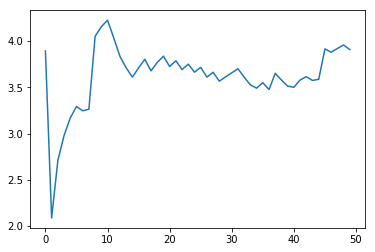

In [119]:
# for test
temp_x = group[['norm_area', 'norm_length', 'norm_num_of_corr', 'norm_A/L', 
                'norm_area quote', 'norm_convex area quote', 'norm_centroid x/width',
                'norm_centroid y/height', 'norm_width/height',
                's1', 's2', 's3', 's4', 's5', 's6', 'r1', 'r2']]#.values.reshape(1, -1)
x = []
temp_result = []
for i in range(50):
    sub_group = group.iloc[:i+1, :]
    mean = sub_group["score"].mean()
    max_x = np.max(sub_group["Left_down_x"].values)
    norm_max_x = np.max(sub_group["norm_left_down_x"].values)
    max_y = np.max(sub_group["Right_down_y"].values)

    area_quote = 1-sub_group["Area"].sum()/(max_x*max_y)
    temp_result.append(mean+area_quote+0.5*norm_max_x)
    x.append(mean+area_quote+0.5*norm_max_x)
plt.plot(x)
plt.show()

In [92]:
# only used when to combien part embedding
# read part embedding
embd = pd.read_pickle('../results/part_embedding.pkl')

In [93]:
# only used when to combien part embedding
embd_train_x = embd.iloc[:int(len(embd)*0.9), :850].values.reshape(int(len(embd)*0.9), 50, -1)
embd_test_x = embd.iloc[int(len(embd)*0.9):, :850].values.reshape(len(embd) - int(len(embd)*0.9), 50, -1)
embd_train_y = embd.iloc[:int(len(embd)*0.9), 850:].values.reshape(int(len(embd)*0.9), 50, -1)
embd_test_y = embd.iloc[int(len(embd)*0.9):, 850:].values.reshape(len(embd) - int(len(embd)*0.9), 50, -1)

In [103]:
train_x.shape

(13771, 50, 17)

In [99]:
# only used when to combien part embedding
train_x = np.concatenate([embd_train_x, train_x], axis = 2)
test_x = np.concatenate([embd_test_x, test_x], axis = 2)
#train_y = np.concatenate([embd_train_y, train_y], axis = 2)
#test_y = np.concatenate([embd_test_y, test_y], axis = 2)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [34]:
# only used when to combien part embedding
# save to the local system
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

In [6]:
# read tmp result
#result = pd.read_csv('../results/features_50labels.csv', index_col = 0)
result = pd.read_pickle('../results/Dataframe_feature_sample6.pkl')

In [9]:
result.shape

(79416, 700)

In [10]:
train_x = result.iloc[:int(len(result)*0.9), :650].values.reshape(int(len(result)*0.9), 50, -1)
test_x = result.iloc[int(len(result)*0.9):, :650].values.reshape(len(result) - int(len(result)*0.9), 50, -1)

In [11]:
train_y = result.iloc[:int(len(result)*0.9), 650:].values.reshape(int(len(result)*0.9), 50, -1)
test_y = result.iloc[int(len(result)*0.9):, 650:].values.reshape(len(result) - int(len(result)*0.9), 50, -1)

In [12]:
# save to the local system
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

In [109]:
result = pd.read_pickle('../results/all_norm_feature.pkl')

In [20]:
test_x = np.load('../data/rnn_train_x.npy')

In [22]:
test_x.shape

(71474, 50, 13)

## bild the rnn model and self-designed method

In [26]:
"""
bild the model, loss and data class, including two different versions
version 1:
seq to seq model
version old:
the old seq to seq model without any paramseters
versioin 2:
seq to 1 model
"""
class TS_rnn(torch.nn.Module):
    """
    scores for each piece
    input:
        tensor size of (batch_size, seq_len, num_dim)
    output:
        tensor size of (batch_size, seq_len)
    """
    def __init__(self, num_hidden = 64, num_layers = 2, dropout = 0.5):
        super(TS_rnn, self).__init__()
        #change the structure of the network
        num_inp = 13
        self.rnn = torch.nn.LSTM(input_size = num_inp, hidden_size = num_hidden, num_layers = num_layers, dropout = dropout)
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(num_hidden, 16),
                torch.nn.Dropout(),
                torch.nn.ReLU(),
                torch.nn.Linear(16, 1)
                )

    def forward(self, inp):
        # input of the rnn (seq_len, batch, input_size)
        data_in = torch.transpose(inp, 0, 1)
        # run rnn, it has two output
        out_rnn, _ = self.rnn(data_in)
        out_rnn = torch.transpose(out_rnn, 0, 1) # (batch_size, seq_len, num_dim)
        # rnn the mlp
        batch_size, seq_len, num_dim = out_rnn.shape
        out = []
        for i in range(seq_len):
            tmp = self.mlp(out_rnn[:, i,:])
            out.append(tmp)
        # now out is list of (batch_size, 1), combine the items in the list to get the output with size (batch_size, seq_len)
        out = torch.cat(out, 1)
        #return out.squeeze() when the batch_size == 1, this can course trouble
        return out

class TS_rnn_old(torch.nn.Module):
    """
    scores for each piece
    input:
        tensor size of (batch_size, seq_len, num_dim)
    output:
        tensor size of (batch_size, seq_len)
    """
    def __init__(self):
        super(TS_rnn_old, self).__init__()
        #change the structure of the network
        num_inp = 13
        num_hidden = 64
        self.rnn = torch.nn.LSTM(input_size = num_inp, hidden_size = num_hidden, num_layers = 2)
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(num_hidden, 16),
                torch.nn.Dropout(),
                torch.nn.ReLU(),
                torch.nn.Linear(16, 1)
                )

    def forward(self, inp):
        # input of the rnn (seq_len, batch, input_size)
        data_in = torch.transpose(inp, 0, 1)
        # run rnn, it has two output
        out_rnn, _ = self.rnn(data_in)
        out_rnn = torch.transpose(out_rnn, 0, 1) # (batch_size, seq_len, num_dim)
        # rnn the mlp
        batch_size, seq_len, num_dim = out_rnn.shape
        out = []
        for i in range(seq_len):
            tmp = self.mlp(out_rnn[:, i,:])
            out.append(tmp)
        # now out is list of (batch_size, 1), combine the items in the list to get the output with size (batch_size, seq_len)
        out = torch.cat(out, 1)
        #return out.squeeze() when the batch_size == 1, this can course trouble
        return out

class TS_rnn2(torch.nn.Module):
    """
    scores only for the whole task
    input:
        tensor size of (batch_size, seq_len, num_dim)
    output:
        tensor size of (batch_size)
    """
    def __init__(self):
        super(TS_rnn2, self).__init__()
        #change the structure of the network
        num_inp = 8
        num_hidden = 64
        self.rnn = torch.nn.LSTM(input_size = num_inp, hidden_size = num_hidden, num_layers = 2)
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(num_hidden, 64),
                torch.nn.Dropout(),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 1)
                )

    def forward(self, inp):
        # input of the rnn (seq_len, batch, input_size)
        data_in = torch.transpose(inp, 0, 1)
        # run rnn, it has two output
        out_rnn, _ = self.rnn(data_in)
        out_rnn = torch.transpose(out_rnn, 0, 1) # (batch_size, seq_len, num_dim)
        # only use the last output
        out_rnn = out_rnn[:, -1, :].squeeze()
        # rnn the mlp
        out = self.mlp(out_rnn)
        return out.squeeze()
    
class PDLoss(torch.nn.Module):
    def __init__(self, p = 2):
        super(PDLoss, self).__init__()
        self.pd = torch.nn.PairwiseDistance(p)

    def forward(self, o, t):
        # out: (batch_size, 1)
        out = self.pd(o, t)
        return out.mean()

class Data:
    """
    data class for TS_rnn
    """
    def __init__(self, x, y):
        self.data = {}
        self.data['train_x'] = self.add_file(x).float()
        self.data['train_y'] = self.add_file(y)[:, :, -1].float() # use the first metric tempately
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def add_file(self, path):
        return torch.from_numpy(np.load(path))

    def add_scores(self, path):
        return torch.FloatTensor([float(li.rstrip('\n')) for li in open(path)])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])

class Data2:
    """
    data class for TS_rnn2
    """
    def __init__(self, x, y):
        self.data = {}
        self.data['train_x'] = self.add_file(x)
        self.data['train_y'] = self.add_file(y)[:, :, -1] # use the first metric tempately
        self.data['train_y'] = torch.mean(self.data['train_y'], 1)
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def add_file(self, path):
        return torch.from_numpy(np.load(path))

    def add_scores(self, path):
        return torch.FloatTensor([float(li.rstrip('\n')) for li in open(path)])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])

'\nbild the model, loss and data class, including two different versions\nversion 1:\nseq to seq model\nversion old:\nthe old seq to seq model without any paramseters\nversioin 2:\nseq to 1 model\n'

In [3]:
# write the test function
def test_model(dl_test, model, loss):
    model.eval()
    test_loss = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        # codes to be changed
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        test_loss += lo.data
    return test_loss/counter

def significant_test(dl_test, model, loss):
    model.eval()
    test_loss = 0
    counter = 0
    hit = 0
    miss = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        # codes to be changed
        inp, target = dat
        out = model(inp)
        target = target.mean(dim = 1)
        #print(out.shape)
        out = out.mean(dim = 1)
        #print(out.shape)
        if len(inp) > 5:
            _, top_target = torch.topk(target, 1, largest=False)
            _, top_predict = torch.topk(out, 5, largest = False)
            if top_target in top_predict:
                hit += 1
            else:
                miss += 1
    return hit * 1.0/(hit + miss)

def metric2(dl_test, model, loss):
    model.eval()
    counter = 0
    hit_count = {}
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        inp, target = dat
        out = model(inp)
        target = target.mean(dim = 1)
        out = out.mean(dim = 1)
        if len(inp) > 5:
            _, index_top_target = torch.topk(target, 1, largest = False)
            _, index_rank = torch.topk(out, len(target), largest = False)
            index_rank = index_rank.tolist()
            index_in_rank = index_rank.index(index_top_target)
            if index_in_rank not in hit_count.keys():
                #print('create new key')
                hit_count[index_in_rank] = 1
            else:
                #print('add one')
                hit_count[index_in_rank] = hit_count[index_in_rank] + 1
    return hit_count

In [4]:
# define method to get the n combination.
def get_combinations(nc, seq, si = 0, com = []):
    """
    input:
    nc, type of int
        set the number of items in one combination
    seq, type of list
        from whom we get the items
    si, type of int
        only consider the items which index larger than si
    com, type of list
        used for recursion, should be set to [] when calling the function
    """
    out = []
    for i in range(si, len(seq)):
        if seq[i] not in com:
            com.append(seq[i])
        else:
            continue
        if len(com) < nc:
            com, tmp_out = get_combinations(nc, seq, i, com)
            out.extend(tmp_out)
        elif len(com) == nc:
            #print(com)
            out.append(com)
            com = com[:-1]
        else:
            print('ERROR!!!')
            #print(com)
    return com[:-1], out

In [ ]:
# run the model
train_x = '../data/rnn_train_x.npy'
train_y = '../data/rnn_train_y.npy'
test_x = '../data/rnn_test_x.npy'
test_y = '../data/rnn_test_y.npy'
num_epochs = 100
batch_size = 30
verbose = True
# set models and loss
model = TS_rnn_old()
#loss = PDLoss()
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
# set the scheduler
lamb1 = lambda x: .1**(x//30)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lamb1)
# loda data
train = Data(train_x, train_y)
test = Data(test_x, test_y)
dl_train = DataLoader(train, batch_size = batch_size, shuffle = True)
dl_test = DataLoader(test, batch_size = batch_size, shuffle = True)
# train the model
for epoch in range(num_epochs):
    scheduler.step()
    model.train()
    train_loss = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_train):
        counter += 1
        # train the model
        optimizer.zero_grad()
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        lo.backward()
        optimizer.step()
        train_loss += lo.data
        if verbose:
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * batch_size,
                    len(train),
                    100.*batch_idx*batch_size/len(train),
                    lo.data
                    ))
    test_lo = test_model(dl_test, model, loss)
    hit_rate = significant_test(dl_test, model, loss)
    if verbose:
        # train loss
        print('====> Epoch: {} Average train loss: {:.4f}'.format(
            epoch,
            train_loss/counter
            ))
        # test loss
        print('====> Epoch: {} Average test loss: {:.4f}'.format(
            epoch,
            test_lo
            ))
        # significant test
        print('====> Epoch: {} Average hit rate in 10 candidate: {: .4f}'.format(
            epoch,
            hit_rate
        ))

TS_rnn_old(
  (rnn): LSTM(13, 64, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 0 [0/71474 (0%)]	Loss: 3.384831
Train Epoch: 0 [300/71474 (0%)]	Loss: 3.120423
Train Epoch: 0 [600/71474 (1%)]	Loss: 2.172904
Train Epoch: 0 [900/71474 (1%)]	Loss: 1.367840
Train Epoch: 0 [1200/71474 (2%)]	Loss: 1.358573
Train Epoch: 0 [1500/71474 (2%)]	Loss: 1.245640
Train Epoch: 0 [1800/71474 (3%)]	Loss: 1.164270
Train Epoch: 0 [2100/71474 (3%)]	Loss: 1.208418
Train Epoch: 0 [2400/71474 (3%)]	Loss: 1.169632
Train Epoch: 0 [2700/71474 (4%)]	Loss: 1.168495
Train Epoch: 0 [3000/71474 (4%)]	Loss: 1.156568
Train Epoch: 0 [3300/71474 (5%)]	Loss: 1.138875
Train Epoch: 0 [3600/71474 (5%)]	Loss: 1.107313
Train Epoch: 0 [3900/71474 (5%)]	Loss: 1.170928
Train Epoch: 0 [4200/71474 (6%)]	Loss: 1.187166
Train Epoch: 0 [4500/71474 (6%)]	Loss: 1.196479
Train Epoch: 0 [4800/71474 (7%)]	Loss: 1.175937
Train Epoch: 0 [5100/71474 (7%)]	Loss: 1.127445
Train Epoch: 0 [5400/71474 (8%)]	Loss: 1.144416
Train Epoch: 0 [5700/71474 (8%)]	Loss: 1.151672
Train Epoch: 0 [6000/71474 (8%)]	Loss: 1.14268

In [39]:
# save model
torch.save(model, '../models/rnn_predict.pkl')

/anaconda3/envs/data_mining/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type TS_rnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
#?? how to get the weight of a mlp model in pytorch

## View the results

In [36]:
# test
test_loss = torch.load('../results/test_loss.pkl')
test_sig = torch.load('../results/test_sig.pkl')
train_loss = torch.load('../results/train_loss.pkl')

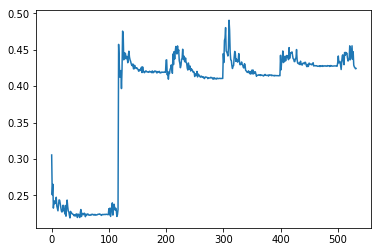

In [37]:
plt.plot(test_loss)

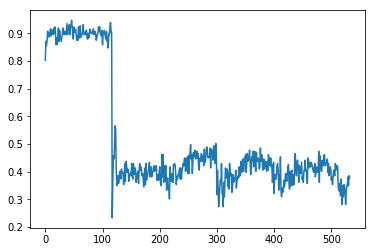

In [38]:
plt.plot(test_sig)

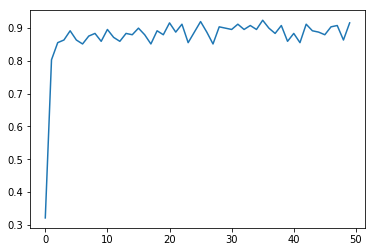

In [55]:
plt.plot(test_sig[:50])

In [ ]:
plt.plot(test_sig[:30])
#plt.figure(figsize = (100, 140))
plt.savefig('../results/test.png', dpi = 200)

In [47]:
mean_mod_wh_l0 = torch.load('../results/mean_mod_wh_l0')
mean_mod_wh_l1 = torch.load('../results/mean_mod_wh_l1')
mean_mod_wi_l0 = torch.load('../results/mean_mod_wi_l0')
mean_mod_wi_l1 = torch.load('../results/mean_mod_wi_l1')

In [48]:
dat = mean_mod_wh_l1
dat = torch.stack(dat, dim = 2)
a = dat[1,1,:]

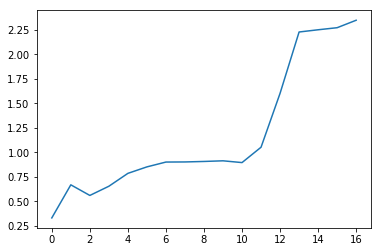

In [52]:
plt.plot(dat[0,7,].tolist())

In [198]:
# 比较weights之间的关系
stds = torch.std(dat, dim =2 )

In [196]:
# test model
model = torch.load('../models/rnn_50.pkl')
dl_test = DataLoader(test, batch_size = 30, shuffle = True)

In [202]:
significant_test(dl_test, model, loss)

0.9285714285714286

In [200]:
hit_count = metric2(dl_test, model, loss)
hit_count = sorted(hit_count.items(), key = lambda x: x[0])

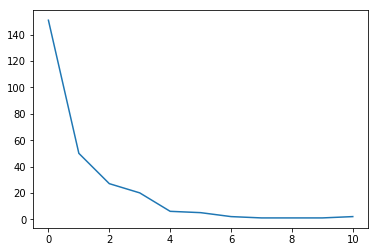

In [201]:
plt.plot([i[1] for i in hit_count])
plt.savefig('../results/hit_count.png', dpi = 200)

In [188]:
plt.savefig('../results/hit_count.png', dpi = 200)

<Figure size 432x288 with 0 Axes>

In [195]:
hit_count

[(0, 36),
 (1, 14),
 (2, 15),
 (3, 3),
 (4, 1),
 (5, 4),
 (6, 1),
 (8, 1),
 (9, 1),
 (11, 2),
 (13, 2)]

In [161]:
# 分析输出
model.eval()
test_loss = 0
counter = 0
out = []
for batch_idx, dat in enumerate(dl_test):
    counter += 1
    # codes to be changed
    inp, target = dat
    tmp = model(inp)
    lo = loss(tmp, target)
    out.append(tmp)
    test_loss += lo.data

TS_rnn(
  (rnn): LSTM(21, 64, num_layers=2, dropout=0.5)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [167]:
a = torch.cat(out, dim = 0)

In [169]:
b = a.mean(dim = 1)

In [180]:
b.std()

tensor(0.3020, grad_fn=<StdBackward0>)

In [205]:
class Tmp:
    """
    data class for TS_rnn
    """
    def __init__(self, x, y):
        self.data = {}
        self.data['train_x'] = x
        self.data['train_y'] = y[:, :, -1].float() # use the first metric tempately
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def add_file(self, path):
        return torch.from_numpy(np.load(path))

    def add_scores(self, path):
        return torch.FloatTensor([float(li.rstrip('\n')) for li in open(path)])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])

In [274]:
cut = 20

In [275]:
# test sort 
test_x = torch.from_numpy(np.load('../results/rnn_test_x.npy'))[:, :cut, :].float()
test_y = torch.from_numpy(np.load('../results/rnn_test_y.npy'))[:, :, :].float()
test = Tmp(test_x, test_y)
dl_test = DataLoader(test, batch_size = 100, shuffle = True)

In [276]:
model = torch.load('../models/rnn_50.pkl')

In [277]:
significant_test(dl_test, model, loss)

0.775

In [252]:
hit_count = metric2(dl_test, model, loss)
hit_count = sorted(hit_count.items(), key = lambda x: x[0])

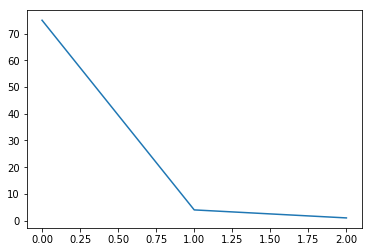

In [282]:
plt.plot([i[1] for i in hit_count])

In [278]:
out = []
for i in range(50):
    cut = i + 1
    test_x = torch.from_numpy(np.load('../results/rnn_test_x.npy'))[:, :cut, :].float()
    test_y = torch.from_numpy(np.load('../results/rnn_test_y.npy'))[:, :, :].float()
    test = Tmp(test_x, test_y)
    dl_test = DataLoader(test, batch_size = 100, shuffle = True)
    out.append(significant_test(dl_test, model, loss))

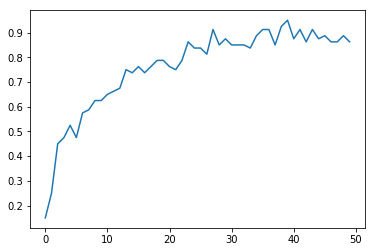

In [283]:
plt.plot(out)
plt.savefig('../results/cut_metric1.png', dpi = 200)

In [134]:
a = []
counter = 1
for i in range(200):
    tmp = random.randint(1,6)
    if tmp == 1:
        counter += 1
    a.append(math.sqrt(i)*0.36/counter)

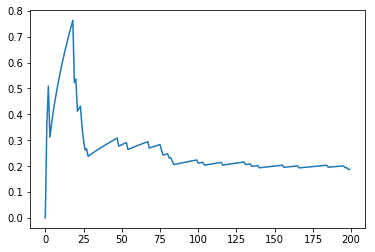

In [135]:
plt.plot(a)

In [116]:
a = []
counter = 1
for i in range(200):
    tmp = random.randint(0,1)
    if tmp == 1:
         counter+= 1
    a.append(counter*1.0/(i+1))

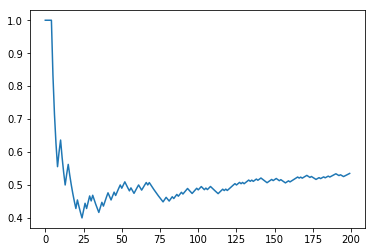

In [117]:
plt.plot(a)